
# The baseline query + purpose and target
The following few shot experiments are done many times to come up with the same conclusion

## prime query 56
## without Dashes 50.6
## With dashes 51.2 %

In [12]:
from openai import OpenAI
import pandas as pd

client = OpenAI()
df = pd.read_csv('verbs.csv')

def translate_verb(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [
            {"role": "system", "content": "You are an expert in Moroccan Darija dialect and in translating Darija to English." +           
            "Translate the provided Moroccan Darija language verbs into English using word-by-word translation." + 
            "Please fulfill the following conditions when translating:"+
            "The output must not be an infinitive verb. No explanations are needed in the output"+
            "Purpose of the translation: To study the accuracy of LLMs on Low resource languages, particularly Darija." + 
            "Target audience: Computational linguists" 
            },
            {
            "role": "user", 
            "content":  f'{verb}' 
            }
        ],        
        temperature=0.1  # Deterministic responses
    )
    return completion.choices[0].message.content

# Apply the translation function to the 'darija_ar' column
df['english_translation'] = df['darija_ar'].apply(translate_verb)

print(df)

           n1       n2     n3       n4       n5    n6 darija_ar         eng  \
0         kla      NaN    NaN      NaN      NaN   NaN       كلا         eat   
1        chrb    chreb    NaN      NaN      NaN   NaN       شرب       drink   
2       dkhel     dkhl  dkhal     d5el      d5l  d5al       دخل       enter   
3        khrj    khraj  khrej      5rj     5raj  5rej       خرج      go out   
4        fhem      fhm   fham     f8em      f8m  f8am       فهم  understand   
...       ...      ...    ...      ...      ...   ...       ...         ...   
1027   bllegh      NaN    NaN      NaN      NaN   NaN      بلّغ      notify   
1028      Tfa      NaN    NaN      NaN      NaN   NaN       طفا    turn off   
1029    ryye7    riye7   ryy7      NaN      NaN   NaN      ريّح    sit down   
1030    ghech  ghechch   ghch    ghach      NaN   NaN        غش       cheat   
1031  9chcher    9cher  qcher  qchcher  9chchar   NaN      قشّر        peel   

     english_translation  
0                    Eat

In [13]:
from nltk.corpus import wordnet as wn

eng = df['eng']
transl = df['english_translation']

transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""
    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score
# Calculate and print the path similarity for each pair of verbs with similar index

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
print(results)



[('Eat', 'eat', 1.0, True), ('drink', 'drink', 1.0, True), ('Enter', 'enter', 1.0, True), ('Exit', 'go_out', 1.0, True), ('Understood', 'understand', 1.0, True), ('Explain', 'explain', 1.0, True), ('Reads', 'learn', 1.0, True), ('Reads', 'teach', 0.25, False), ('hear', 'hear', 1.0, True), ('saw', 'see', 1.0, True), ('Smell', 'smell', 1.0, True), ('Called', 'taste', 0.3333333333333333, False), ('Measure', 'touch', 0.25, False), ('Went', 'go', 1.0, True), ('Came', 'come', 1.0, True), ('Go_out', 'ascend', 0.3333333333333333, False), ('Went_down', 'go_down', 0, False), ('Year', 'swim', 0, False), ('Drown', 'drown', 1.0, True), ('Wear', 'wear', 1.0, True), ('Asked', 'take_off', 0.25, False), ('Buy', 'buy', 1.0, True), ('sold', 'sell', 1.0, True), ('Come', 'bargain', 0.14285714285714285, False), ('write', 'write', 1.0, True), ('wipe', 'clean', 0.16666666666666666, False), ('hit', 'hit', 1.0, True), ('You_peace', 'salute', 0, False), ('Tired', 'fatigue', 1.0, True), ('Shuffle', 'exhaust', 0.2

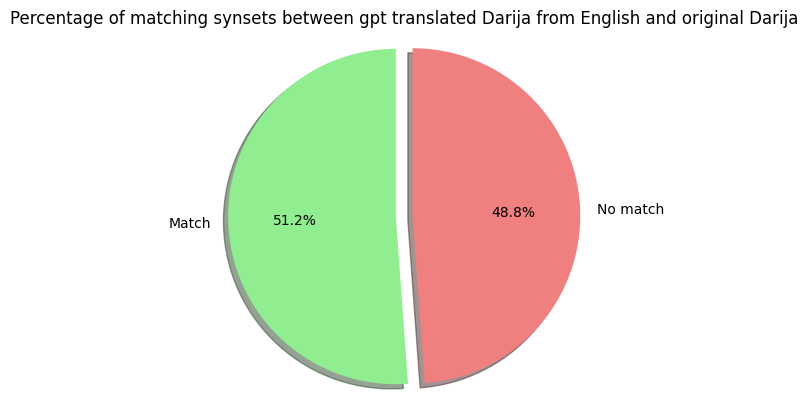

In [14]:
import matplotlib.pyplot as plt

# Extract the last element of each tuple in the list (representing True or False values)
last_elements = [result for *_, result in results]

# Count how many comparisons are True
true_count = sum(last_elements)  # True evaluates to 1, so summing directly counts the True values

# Calculate the percentage of True vs False
total_comparisons = len(results)
false_count = total_comparisons - true_count

# Plot pie chart
labels = 'Match', 'No match'
sizes = [true_count, false_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of matching synsets between gpt translated Darija from English and original Darija")
plt.show()